In [1]:
import cometspy as c 
import cobra
import cobra.io
from cobra.io import read_sbml_model
from matplotlib import pyplot as plt
import gurobipy

In [2]:
ecoli_wt = read_sbml_model("iML1515.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-07-12


In [3]:
#Creation of the cobra models
ecoli_CAT_bound=ecoli_wt.copy()
ecoli_CAT_bound.reactions.get_by_id("GAPD").bounds=(1000,1000)

ecoli_ATPS4rpp_GAPD_E4PD_KO=ecoli_wt.copy()
ecoli_ATPS4rpp_GAPD_E4PD_KO.reactions.ATPS4rpp.knock_out()
ecoli_ATPS4rpp_GAPD_E4PD_KO.reactions.GAPD.knock_out()
ecoli_ATPS4rpp_GAPD_E4PD_KO.reactions.E4PD.knock_out()

ecoli_ATPS4rpp_GAPD_E4PD_KO.id="ATPS4rpp,GAPD,E4PD_KO"
ecoli_wt.id = "wt"
ecoli_CAT_bound.id = "CAT_bound"

Read LP format model from file /tmp/tmp_icetx2y.lp
Reading time = 0.02 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Read LP format model from file /tmp/tmpo724cn5r.lp
Reading time = 0.03 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


In [4]:
#Creation of comets model with initial populations (sum=0.1)
wt_comets = c.model(ecoli_wt)
wt_comets.initial_pop = [0,0,0.06] # x, y, gDW
wt_comets.open_exchanges()

ecoli_ATPS4rpp_GAPD_E4PD_KO_comets=c.model(ecoli_ATPS4rpp_GAPD_E4PD_KO)
ecoli_ATPS4rpp_GAPD_E4PD_KO_comets.initial_pop = [0,0,0.02]
ecoli_ATPS4rpp_GAPD_E4PD_KO_comets.open_exchanges()

ecoli_CAT_bound_commets = c.model(ecoli_CAT_bound)
ecoli_CAT_bound_commets.initial_pop = [0,0,0.02] # x, y, gDW
ecoli_CAT_bound_commets.open_exchanges()



In [5]:
#Set the exchange metabolite names from LB
import pandas as pd
df = pd.read_csv('media_db.tsv', sep='\t')
filtered_rows = df[df.iloc[:, 0] == 'LB']
metabolites_LB = filtered_rows.iloc[:, 2].tolist()
exchange_metabolites_LB = []
for i in metabolites_LB:
    new_element = str(i) + "_e"
    exchange_metabolites_LB.append(new_element)
print(exchange_metabolites_LB)
elements_to_remove_LB = ['cro4_e', 'fol_e',"ribflv_e"]
exchange_metabolites_LB = [x for x in exchange_metabolites_LB if x not in elements_to_remove_LB]


['adn_e', 'ala__L_e', 'amp_e', 'arg__L_e', 'aso3_e', 'asp__L_e', 'ca2_e', 'cbl1_e', 'cd2_e', 'cl_e', 'cmp_e', 'cobalt2_e', 'cro4_e', 'cu2_e', 'cys__L_e', 'dad_2_e', 'dcyt_e', 'fe2_e', 'fe3_e', 'fol_e', 'glc__D_e', 'glu__L_e', 'gly_e', 'gmp_e', 'gsn_e', 'h2o_e', 'h2s_e', 'h_e', 'hg2_e', 'his__L_e', 'hxan_e', 'ile__L_e', 'ins_e', 'k_e', 'leu__L_e', 'lipoate_e', 'lys__L_e', 'met__L_e', 'mg2_e', 'mn2_e', 'mobd_e', 'na1_e', 'nac_e', 'nh4_e', 'ni2_e', 'o2_e', 'phe__L_e', 'pheme_e', 'pi_e', 'pnto__R_e', 'pro__L_e', 'pydx_e', 'ribflv_e', 'ser__L_e', 'so4_e', 'thm_e', 'thr__L_e', 'thymd_e', 'trp__L_e', 'tyr__L_e', 'ump_e', 'ura_e', 'uri_e', 'val__L_e', 'zn2_e']


In [6]:
#Build the layout with the models of interest and set the media with the list of LB metabolites
ly_LB = c.layout([ecoli_ATPS4rpp_GAPD_E4PD_KO_comets,ecoli_CAT_bound_commets,wt_comets])
for metabolite in exchange_metabolites_LB:
    ly_LB.set_specific_metabolite(metabolite,1000,static=False)
ly_LB.set_specific_metabolite("glc__D_e", 100)
ly_LB.set_specific_metabolite('o2_e',0) #anaerobic condition

In [36]:
#Set parameters of the simulation
p = c.params()
p.set_param("timeStep", 0.1)
p.set_param("maxCycles", 15)
p.set_param("useLogNameTimeStamp", False)
p.set_param("spaceWidth",0.05)
p.set_param("allowCellOverlap",True)
p.set_param("cellSize",4.3e-13)
p.set_param("deathRate", 0.00)
p.set_param("dilFactor",1e-2)
p.set_param("dilTime", 12)
p.set_param("numRunThreads", 1)
p.set_param("maxSpaceBiomass",100)
p.set_param("defaultVmax",20)
p.set_param("defaultKm",0.01)
p.set_param("defaultHill",1)
p.set_param("showCycleTime", True)
p.set_param("geneFractionalCost", 0)
p.set_param("writeTotalBiomassLog", True)
p.set_param("writeBiomassLog", True)
p.set_param("writeMediaLog",True)
p.set_param("useLogNameTimeStamp", False)
p.set_param("flowDiffRate", 1e-7)
p.set_param("growthDiffRate",1e-7)
p.set_param("FluxLogRate", 1)
p.set_param("MediaLogRate", 1)
p.set_param("numExRxnSubsteps",12)
p.set_param("geneFractionalCost",0)
p.set_param("exchangestyle", "Standard FBA")
p.set_param("biomassMotionStyle","Diffusion 2D(Crank-Nicolson)")
p.set_param("mutRate",1e-9)
p.set_param("addRate", 1e-9)
p.set_param("minSpaceBiomass", 1e-10)

In [37]:
#Only wild-type model in the same LB media
wt_comets_all = c.model(ecoli_wt)
wt_comets_all.initial_pop = [0,0,0.1] 
wt_comets_all.open_exchanges()

ly_LB_wt=c.layout([wt_comets_all])
for metabolite in exchange_metabolites_LB:
    ly_LB_wt.set_specific_metabolite(metabolite,1000,static=False)
ly_LB_wt.set_specific_metabolite("glc__D_e", 100)
ly_LB_wt.set_specific_metabolite('o2_e',0)


Running COMETS simulation ...


/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-

Done!


Text(0, 0.5, 'biomass (gDW)')

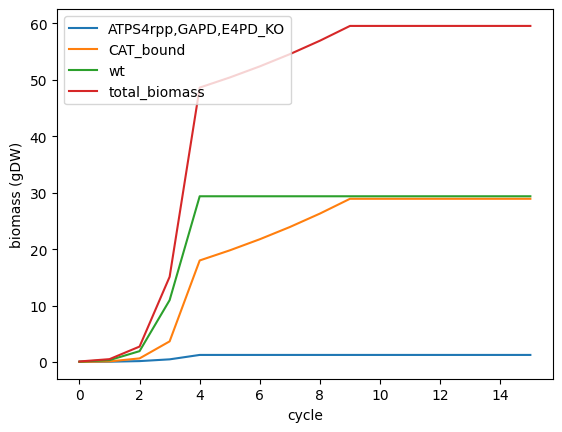

In [38]:
#Run the query simulation
sim_LB= c.comets(ly_LB, p)
sim_LB.run(delete_files=True)
sim_LB.total_biomass['total_biomass'] = sim_LB.total_biomass.iloc[:, 1:].sum(axis=1)
sim_LB.total_biomass.plot(x = "cycle",logy = False)
plt.ylabel("biomass (gDW)")


Running COMETS simulation ...


/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)


Done!


Text(0, 0.5, 'biomass (gDW)')

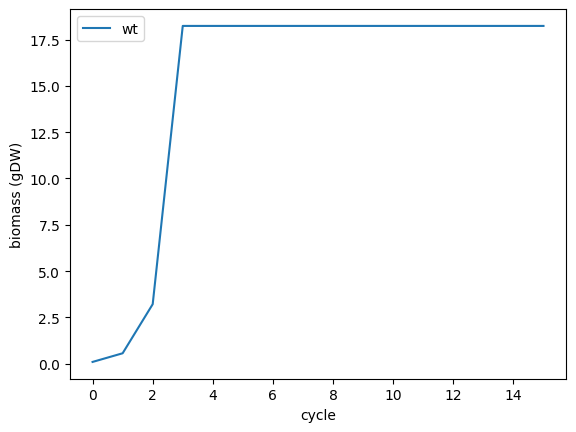

In [39]:
#Run the control simulation
sim_LB_wt= c.comets(ly_LB_wt, p)
sim_LB_wt.run(delete_files=True)
sim_LB_wt.total_biomass.plot(x = "cycle",logy = False)
plt.ylabel("biomass (gDW)")

In [40]:
#New simulation with the values of the 3rd cycle simulation
media_LB_cycle3 = sim_LB.media[sim_LB.media['cycle']==3]
pop_LB_cycle3=sim_LB.total_biomass[sim_LB.total_biomass['cycle']==3]
wt_comets_aerobic = c.model(ecoli_wt)
wt_comets_aerobic.initial_pop = [0,0,pop_LB_cycle3.loc[3,"wt"]] # x, y, gDW
wt_comets_aerobic.open_exchanges()

ecoli_ATPS4rpp_GAPD_E4PD_KO_comets_aerobic=c.model(ecoli_ATPS4rpp_GAPD_E4PD_KO)
ecoli_ATPS4rpp_GAPD_E4PD_KO_comets_aerobic.initial_pop = [0,0,pop_LB_cycle3.loc[3,"ATPS4rpp,GAPD,E4PD_KO"]]
ecoli_ATPS4rpp_GAPD_E4PD_KO_comets_aerobic.open_exchanges()

ecoli_CAT_bound_commets_aerobic=ecoli_CAT_bound_commets
ecoli_CAT_bound_commets_aerobic.initial_pop = [0,0,pop_LB_cycle3.loc[3,"CAT_bound"]]
ecoli_CAT_bound_commets_aerobic.open_exchanges()

ly_LB_aerobic=c.layout([ecoli_ATPS4rpp_GAPD_E4PD_KO_comets_aerobic,wt_comets_aerobic,ecoli_CAT_bound_commets_aerobic])
for index, row in media_LB_cycle3.iterrows():
    metabolite = row['metabolite']
    conc_mmol = row['conc_mmol']
    ly_LB_aerobic.set_specific_metabolite(metabolite, conc_mmol)
ly_LB_aerobic.set_specific_metabolite("o2_e", 1000,static=True)

In [41]:
media_LB_wt_cycle3 = sim_LB_wt.media[sim_LB_wt.media['cycle']==3]
pop_LB_wt_cycle3=sim_LB_wt.total_biomass[sim_LB_wt.total_biomass['cycle']==3]
wt_comets_aerobic_all = c.model(ecoli_wt)
wt_comets_aerobic_all.initial_pop = [0,0,pop_LB_wt_cycle3.loc[3,"wt"]] # x, y, gDW
wt_comets_aerobic_all.open_exchanges()
ly_LB_aerobic_wt=c.layout([wt_comets_aerobic_all])
for index, row in media_LB_wt_cycle3.iterrows():
    metabolite = row['metabolite']
    conc_mmol = row['conc_mmol']
    ly_LB_aerobic_wt.set_specific_metabolite(metabolite, conc_mmol)
ly_LB_aerobic_wt.set_specific_metabolite("o2_e", 1000,static=True)


In [42]:
#Simulation of heretogeneous population in LB aerobic, 
sim_LB_aerobic= c.comets(ly_LB_aerobic, p)
sim_LB_aerobic.run(delete_files=True)



Running COMETS simulation ...


/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-

Done!


Text(0, 0.5, 'biomass (gDW)')

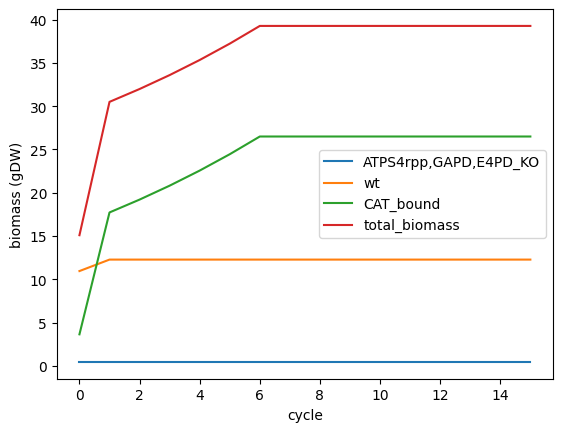

In [43]:
sim_LB_aerobic.total_biomass['total_biomass'] = sim_LB_aerobic.total_biomass.iloc[:, 1:].sum(axis=1)
sim_LB_aerobic.total_biomass.plot(x = "cycle")
plt.ylabel("biomass (gDW)")

Text(0, 0.5, 'biomass (gDW)')

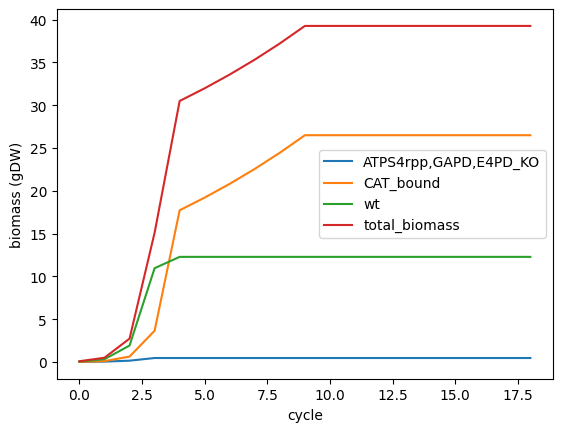

In [44]:
#Mixed plots in LB from nanerobic to aerobic in cycle 3
end_anaerobic=sim_LB.total_biomass[sim_LB.total_biomass['cycle']<3]
init_aerobic=sim_LB_aerobic.total_biomass.copy()
init_aerobic["cycle"]=init_aerobic["cycle"]+3
sim_LB_anaerobic_aerobic = pd.concat([end_anaerobic, init_aerobic], axis=0)
sim_LB_anaerobic_aerobic.set_index("cycle")
sim_LB_anaerobic_aerobic.plot(x = "cycle")
plt.ylabel("biomass (gDW)")


Running COMETS simulation ...


/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:973: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  smat.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:979: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  bnd.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:987: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  met_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)
/home/elisa/.local/lib/python3.10/site-packages/cometspy/model.py:991: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  rxn_n.to_csv(f, mode='a', line_terminator = '\n', header=False, index=False)


Done!


Text(0, 0.5, 'biomass (gDW)')

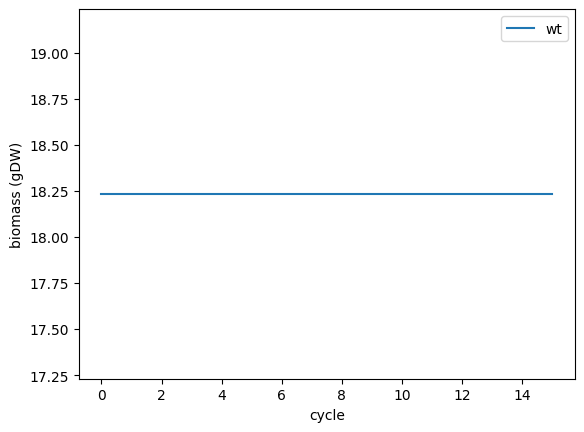

In [45]:
#Aeobic forr wt only
sim_LB_aerobic_wt= c.comets(ly_LB_aerobic_wt, p)
sim_LB_aerobic_wt.run(delete_files=True)
sim_LB_aerobic_wt.total_biomass.plot(x = "cycle")
plt.ylabel("biomass (gDW)")